PhD-EE Homework 7 |
Kelly Lifchez   |
March 10 2025   |

In [4]:

# Clear all
from IPython import get_ipython
get_ipython().magic('reset -sf')

# Install missing package
%pip install rdd

# Import packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm    
from linearmodels.iv import IV2SLS
from scipy import stats
from linearmodels.iv import IVGMM
import rdd

# set working directories 
inputpath = r'/Users/kellylifchez/GaTech Dropbox/Kelly Lifchez/phdee-KL/homework7/data'
outputpath = r'/Users/kellylifchez/GaTech Dropbox/Kelly Lifchez/phdee-KL/homework7/output'

# Set seed
np.random.seed(6578103)

df = pd.read_csv(os.path.join(inputpath, 'instrumentalvehicles.csv'))


/var/folders/0k/hqc4k_wd6rb1k8ff1_qqwjhw0000gn/T/ipykernel_10462/1531041134.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -sf')


  Preparing metadata (setup.py) ... done
  Created wheel for rdd: filename=rdd-0.0.3-py3-none-any.whl size=4701 sha256=301e7925df53aa23b7a3c4e952834f60d0f0b5cb05dcf53090354707c8186dc1
  Stored in directory: /Users/kellylifchez/Library/Caches/pip/wheels/b5/ab/24/f7eb5a30c63a0be0408237e213a530195a16cf656dede5de36
Successfully built rdd
Note: you may need to restart the kernel to use updated packages.


**Question 2:** Create a scatterplot with mpg on the y-axis and length-cutoff on the x-axis with a line at the RD cutoff. 

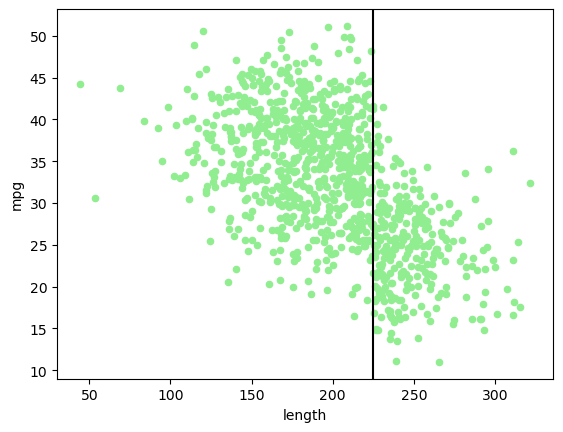

In [24]:
# Scatterplot
os.chdir(outputpath)
df.plot.scatter(x ='length', y = 'mpg', color='#90EE90')
plt.axvline(x=225, color = "black")
plt.savefig('scatter_py_q2.pdf',format= 'pdf')
plt.show()



**Question 3:** Fit a first-order polynomial to both sides of the cutoff in a rdd. 

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.184
Date:                Mon, 10 Mar 2025   Prob (F-statistic):             0.0755
Time:                        20:07:34   Log-Likelihood:                -875.41
No. Observations:                 280   AIC:                             1755.
Df Residuals:                     278   BIC:                             1762.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.5120      3.917      8.045      0.0

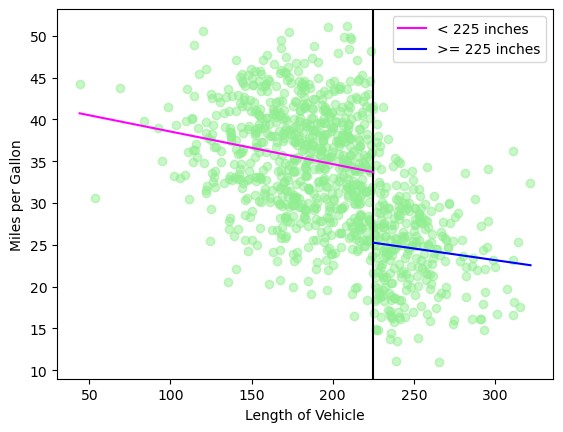

In [40]:
# Set cutoff
cutoff = 225
df['policy']=(df['length']>=cutoff).astype(int)


X= df['length']
X = sm.add_constant(X)

X_right = X[df['policy'] == 1] # to the right of the cutoff
Y_right = df[df['policy']==1]['mpg']

X_left = X[df['policy'] == 0] # to the left of the cutoff
Y_left = df[df['policy']==0]['mpg']

linearright = sm.OLS(Y_right, X_right).fit()
linearleft = sm.OLS(Y_left, X_left).fit()

print(linearright.summary())
print(linearleft.summary())

# Save estimated coefficients to the righgt of the cutoff
coef = linearright.params.to_numpy() 
coef[1]

# Save estimated coefficients to the left of the cutoff
coefb = linearleft.params.to_numpy() 
coefb[1]

#Calculate the predicted values of mpg
effect = coef[1]-coefb[1]
effect


X_hat_left = np.linspace(X_left['length'].min(), X_left['length'].max(), 1000)
X_hat_left = sm.add_constant(X_hat_left)
Y_hat_left = linearleft.predict(X_hat_left)

X_hat_right = np.linspace(X_right['length'].min(), X_right['length'].max(), 1000)
X_hat_right = sm.add_constant(X_hat_right)
Y_hat_right = linearright.predict(X_hat_right)

os.chdir(outputpath)
plt.scatter(df['length'], df['mpg'], color='#90EE90', alpha = 0.5)
plt.axvline(x=225, color='black')
plt.plot(X_hat_left[:, 1], Y_hat_left, color='magenta', label='< 225 inches')
plt.plot(X_hat_right[:, 1], Y_hat_right, color='blue', label='>= 225 inches')
plt.xlabel('Length of Vehicle')
plt.ylabel('Miles per Gallon')
plt.legend()
plt.savefig('rdd_py_q3.pdf',format= 'pdf')
plt.show()


**Question 4:** Fit a second-order polynomial to both sides of the cutoff in a regression discontinuity design. 

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     237.2
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           5.62e-85
Time:                        20:07:23   Log-Likelihood:                -3294.2
No. Observations:                1000   AIC:                             6594.
Df Residuals:                     997   BIC:                             6609.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.5552      3.239     10.978      0.0

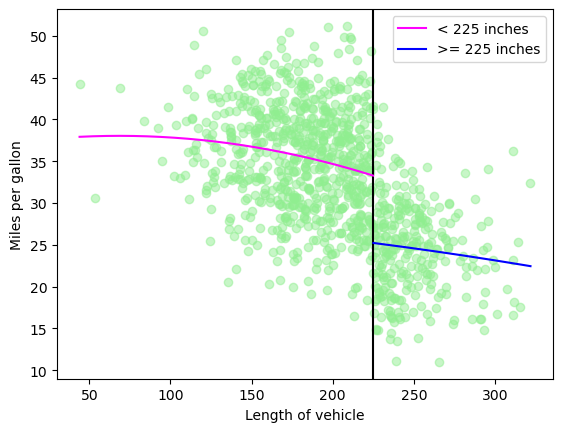

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import os

# Set cutoff
cutoff = 225
df['policy'] = (df['length'] >= cutoff).astype(int)

X_right = df[df['policy'] == 1][['length']]
Y_right = df[df['policy'] == 1]['mpg']

X_left = df[df['policy'] == 0][['length']]
Y_left = df[df['policy'] == 0]['mpg']

X_right_2 = sm.add_constant(np.column_stack((X_right, X_right**2)))
X_left_2 = sm.add_constant(np.column_stack((X_left, X_left**2)))

X_2 = sm.add_constant(np.column_stack((df['length'], df['length']**2)))

secondorder_right = sm.OLS(Y_right, X_right_2).fit()
secondorder_left = sm.OLS(Y_left, X_left_2).fit()

secondorder = sm.OLS(df['mpg'], X_2).fit()

print(secondorder.summary())
with open("est_py_q4.tex", "w") as f:
    f.write(secondorder.summary().as_latex())

print(secondorder_right.summary())
print(secondorder_left.summary())

coef2 = secondorder_right.params.to_numpy()
coef2[1]
coefb2 = secondorder_left.params.to_numpy()
coefb2[1]

effect = coef2[1] - coefb2[1]
effect

# Create scatterplot
os.chdir(outputpath)

plt.scatter(df['length'], df['mpg'], color='#90EE90', alpha=0.5)
plt.axvline(x=225, color='black')

X_hat_left = np.linspace(X_left['length'].min(), X_left['length'].max(), 1000)
Y_hat_left = secondorder_left.predict(sm.add_constant(np.column_stack((X_hat_left, X_hat_left**2))))
plt.plot(X_hat_left, Y_hat_left, color='magenta', label='< 225 inches')

X_hat_right = np.linspace(X_right['length'].min(), X_right['length'].max(), 1000)
Y_hat_right = secondorder_right.predict(sm.add_constant(np.column_stack((X_hat_right, X_hat_right**2))))
plt.plot(X_hat_right, Y_hat_right, color='blue', label='>= 225 inches')

plt.xlabel('Length of vehicle')
plt.ylabel('Miles per gallon')
plt.legend()
plt.savefig('rdd_py_q4.pdf', format='pdf')
plt.show()

**Question 5:** Fit a fifth-order polynomial to both sides of the cutoff in a regression discontinuity design. 

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.570
Date:                Mon, 10 Mar 2025   Prob (F-statistic):              0.183
Time:                        20:07:11   Log-Likelihood:                -873.85
No. Observations:                 280   AIC:                             1758.
Df Residuals:                     275   BIC:                             1776.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3783      0.358      1.057      0.2

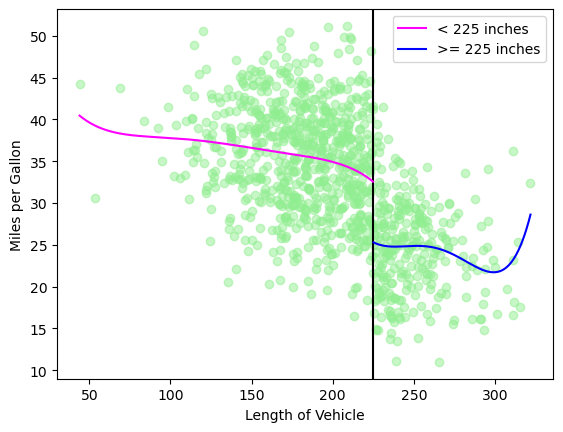

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import os

# Set cutoff
cutoff = 225
df['policy'] = (df['length'] >= cutoff).astype(int)

# Prepare the data for fifth-order polynomial regression
X_right = df[df['policy'] == 1][['length']]
Y_right = df[df['policy'] == 1]['mpg']

X_left = df[df['policy'] == 0][['length']]
Y_left = df[df['policy'] == 0]['mpg']

# Add polynomial terms up to the fifth order
X_right_5 = sm.add_constant(np.column_stack([X_right**i for i in range(1, 6)]))
X_left_5 = sm.add_constant(np.column_stack([X_left**i for i in range(1, 6)]))

# Fit the fifth-order polynomial regression models
fifthorder_right = sm.OLS(Y_right, X_right_5).fit()
fifthorder_left = sm.OLS(Y_left, X_left_5).fit()

# Print the summaries of the models
print(fifthorder_right.summary())
print(fifthorder_left.summary())

# Calculate the predicted values for plotting
X_hat_left = np.linspace(X_left['length'].min(), X_left['length'].max(), 1000)
X_hat_left_5 = sm.add_constant(np.column_stack([X_hat_left**i for i in range(1, 6)]))
Y_hat_left = fifthorder_left.predict(X_hat_left_5)

X_hat_right = np.linspace(X_right['length'].min(), X_right['length'].max(), 1000)
X_hat_right_5 = sm.add_constant(np.column_stack([X_hat_right**i for i in range(1, 6)]))
Y_hat_right = fifthorder_right.predict(X_hat_right_5)

# Create scatterplot
os.chdir(outputpath)

plt.scatter(df['length'], df['mpg'], color='#90EE90', alpha=0.5)
plt.axvline(x=225, color='black')

plt.plot(X_hat_left, Y_hat_left, color='magenta', label='< 225 inches')
plt.plot(X_hat_right, Y_hat_right, color='blue', label='>= 225 inches')

plt.xlabel('Length of Vehicle')
plt.ylabel('Miles per Gallon')
plt.legend()

# Save the figure to the specified output path
plt.savefig('rdd_py_q5.pdf', format='pdf')
plt.show()

**Question 6:** Using the discontinuity as an instrument for miles per gallon, estimate the impact of mpg on the vehicle’s sale price using 2SLS by hand.

In [35]:
## First Stage
from statsmodels.formula.api import ols
first = ols('mpg ~ policy + car', data=df).fit()
print(first.summary())

mpg_hat = first.fittedvalues
mpg_hat = pd.Series(mpg_hat, index = df.index)

Z =  df[['price','car']]
Z = pd.concat([Z,mpg_hat], axis =1)
Z
colnames = ['price','car','mpg_hat']
Z.columns = colnames

## Second Stage 
from statsmodels.formula.api import ols
secondstage = ols('price ~ mpg_hat + car', data=Z).fit()
print(secondstage.summary())
with open("2sls_py_q6.tex", "w") as f: f.write(secondstage.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     651.0
Date:                Mon, 10 Mar 2025   Prob (F-statistic):          1.34e-181
Time:                        19:52:33   Log-Likelihood:                -3071.1
No. Observations:                1000   AIC:                             6148.
Df Residuals:                     997   BIC:                             6163.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.5594      0.271    116.627      0.0